# Handle imports

In [9]:
#!pip install langchain langchain-core langgraph cassio langchain_community tiktoken langchain-groq langchainhub langchain_huggingface arxiv wikipedia python-dotenv pandas

In [10]:
from dotenv import load_dotenv
import os
import cassio
from uuid import uuid4
import numpy as np
import pandas as pd
import json
import pandas as pd


from typing import Literal,List,Annotated

from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage,trim_messages,AIMessage,HumanMessage,RemoveMessage
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.documents import Document


from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import add_messages

from typing_extensions import TypedDict

from transformers import BertTokenizer,BertModel
import pickle as pkl

load_dotenv()

True

In [11]:
unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY') # Update to your API key

In [12]:
from langsmith import Client
client = Client()

# Connect to the database

In [13]:
# ingredients_db = pkl.load(open('Dataset/preprocessed_data_with_embeddings.pkl', 'rb'))
#ingredients_db = pkl.load(open('data_with_embeddings.pkl', 'rb'))
ingredients_db = pkl.load(open('data_with_embeddings.pkl', 'rb'))

In [14]:
ingredients_db.head()

,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,embedding
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,"[[-0.59116715, 0.33531493, 0.21361381, 0.00762..."
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,"[[-0.7548754, -0.17421031, -0.18798593, -0.033..."
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,"[[-0.8293739, -0.21399453, -0.36995414, 0.2343..."
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,"[[-0.26910004, 0.18916038, -0.0077009723, 0.09..."
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,"[[-0.15759984, 0.3318352, 0.066735335, -0.0022..."


In [15]:
# connection of Astra DB
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id = ASTRA_DB_ID
)

In [16]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [17]:
from langchain.vectorstores import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name = "CNM_test_table",
                               session=None,
                               keyspace=None)

In [18]:
workout_retriever = astra_vector_store.as_retriever(    
                                                search_type="similarity_score_threshold",
                                                search_kwargs={"k": 2, "score_threshold": 0.8},
                                                )   
workout_retriever.invoke("Give me an upper body workout")

No relevant docs were retrieved using the relevance score threshold 0.8


[]

# Langgraph

### Datamodel

In [19]:
class GeneralRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["workout","general"] = Field(
        ...,
        description="Given a user question choose to route it to general chat or a workout"
    )

class ToolRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["workout_plan","exercise"] = Field(
        ...,
        description="Given a user question choose to route it to workout_plan or exercise"
    )

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: recent message history
        preferences: uses' workout preferences
        documents: list of documents
        
    """
    messages: Annotated[list[AnyMessage], add_messages]
    documents: List[str]
    preferences: str
    #BodyPart: str
    workout_plan: dict
    redo: str
    level : str

### LLM links

In [20]:
from langchain_groq import ChatGroq
# from google.colab import userdata
import os
groq_api_key = os.getenv('groq_api_key')
# print(groq_api_key)

In [21]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')
chat_llm = ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')

structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)


### Prompts

In [22]:
# General router Prompt
system = """You are an expert at routing a user question to a workout or general.
The workout can tools to take care of workout planning, exercise finding and creation.
Use the workout for questions on these topics. Otherwise, use general."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_router = route_prompt | structured_llm_general_router

# print(general_router.invoke({"messages": "what is stardew Valley"}))
# print(general_router.invoke({"messages": "How to make a sweet dessert"}))

In [23]:
# tool router Prompt
system = """
You are an expert at routing a user message to a workout_plan or exercise.
the workout_plan has access to tools to generate a workout plan for your weight goals.
Use the workout_plan for questions on these topics. 
If the message has to do with finding or modifying a exercise, use exercise.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

tool_router = route_prompt | structured_llm_tool_router

# print(tool_router.invoke({"messages": "how to make butter chicken"}))
# print(tool_router.invoke({"messages": "help me plan the workout for the week"}))

In [24]:
# General Chat Prompt
system = """You are a helpful health coach that answers questions to the best of your ability.
Here is the information you have about the user:
preferences: {preferences} 

workout_plan: {workout_plan}
"""
general_chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_chat = general_chat_prompt | chat_llm

In [25]:
temp_docs = """
[Document(id='730eabbda8404509911d1414f5b54874', metadata={'description': 'Step 1\r\nStarting Position: Stand under the chin-up bar and reach your arms overhead with your palms facing you.\xa0 Reach, jump or lift your body off the floo', 'language': 'en', 'source': 'https://www.acefitness.org/resources/everyone/exercise-library/190/chin-ups/', 'title': 'Arm Exercises | Chin-ups '}, page_content='Arm Exercises | Chin-ups \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAsset 19\nangle-down-bold\nangle-left-bold\nangle-right-bold\nangle-up-bold\n\n\n\nAsset 10\n\n\n\n\n\ncertifications\n\nAsset 14\n\n\n\n\nclose-bold\nclose\n\n\n\n\n\nAsset 8\n\nAsset 12\n\n\n\n\nmenu\nAsset 18\nAsset 17\nAsset 6\n\nAsset 16\n\n\n\n\n\n\n\n\nAsset 9\nAsset 15\nAsset 11\n\n\nAsset 13\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nACE Fitness\n\n\n\n\n\n\r\n                            Certification \n\n\n\n\n\n\r\n                            Continuing\r\n                            Education \n\n\n\n\n\n\r\n                            Resources \n\n\n\n\n\n\r\n                            About \n\n\n\n\n\n\r\n                            ACE\r\n                            IMPACT \n\n\n\n\n\n\n\nTALK TO AN ADVISOR!\n\n\n\n\n\n\n\r\n                            Talk to an Advisor\r\n                        \n\n\n\nYour Cart (0)\n 0\n\n\nSign In\n\n\n\n\n\n\n\n\n\n\n\n\n\nSign In\n\n\n\n\n\n\n\n\n Certification\n\n\n\n\n\n\n\nNEW EXAM OPTION! Personal Trainer'),
 Document(id='28fee3d3d7384c5fadc62003f6c367c8', metadata={'description': 'Place a barbell in a squat rack so that the bar is slightly lower than shoulder height, and\xa0grip the bar with the\xa0hands about shoulder-width apart. Di', 'language': 'en', 'source': 'https://www.acefitness.org/resources/everyone/exercise-library/24/push-press/', 'title': 'Full Body/Integrated Exercises | Push Press'}, page_content='Full Body/Integrated Exercises | Push Press\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAsset 19\nangle-down-bold\nangle-left-bold\nangle-right-bold\nangle-up-bold\n\n\n\nAsset 10\n\n\n\n\n\ncertifications\n\nAsset 14\n\n\n\n\nclose-bold\nclose\n\n\n\n\n\nAsset 8\n\nAsset 12\n\n\n\n\nmenu\nAsset 18\nAsset 17\nAsset 6\n\nAsset 16\n\n\n\n\n\n\n\n\nAsset 9\nAsset 15\nAsset 11\n\n\nAsset 13\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nACE Fitness\n\n\n\n\n\n\r\n                            Certification \n\n\n\n\n\n\r\n                            Continuing\r\n                            Education \n\n\n\n\n\n\r\n                            Resources \n\n\n\n\n\n\r\n                            About \n\n\n\n\n\n\r\n                            ACE\r\n                            IMPACT \n\n\n\n\n\n\n\nTALK TO AN ADVISOR!\n\n\n\n\n\n\n\r\n                            Talk to an Advisor\r\n                        \n\n\n\nYour Cart (0)\n 0\n\n\nSign In\n\n\n\n\n\n\n\n\n\n\n\n\n\nSign In\n\n\n\n\n\n\n\n\n Certification\n\n\n\n\n\n\n\nNEW EXAM OPTION! Personal Trainer'),
 Document(id='dcf7bf8018b3459ab65c9a4ff6753f84', metadata={'description': 'Master the back squat to build leg strength and improve fitness. Learn proper technique inthe ACE Exercise Library.', 'language': 'en', 'source': 'https://www.acefitness.org/resources/everyone/exercise-library/11/back-squat/', 'title': 'Back Squat Exercise Guide | ACE Fitness'}, page_content='Back Squat Exercise Guide | ACE Fitness\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAsset 19\nangle-down-bold\nangle-left-bold\nangle-right-bold\nangle-up-bold\n\n\n\nAsset 10\n\n\n\n\n\ncertifications\n\nAsset 14\n\n\n\n\nclose-bold\nclose\n\n\n\n\n\nAsset 8\n\nAsset 12\n\n\n\n\nmenu\nAsset 18\nAsset 17\nAsset 6\n\nAsset 16\n\n\n\n\n\n\n\n\nAsset 9\nAsset 15\nAsset 11\n\n\nAsset 13\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nACE Fitness\n\n\n\n\n\n\r\n                            Certification \n\n\n\n\n\n\r\n                            Continuing\r\n                            Education \n\n\n\n\n\n\r\n                            Resources \n\n\n\n\n\n\r\n                            About \n\n\n\n\n\n\r\n                            ACE\r\n                            IMPACT \n\n\n\n\n\n\n\nTALK TO AN ADVISOR!\n\n\n\n\n\n\n\r\n                            Talk to an Advisor\r\n                        \n\n\n\nYour Cart (0)\n 0\n\n\nSign In\n\n\n\n\n\n\n\n\n\n\n\n\n\nSign In\n\n\n\n\n\n\n\n\n Certification\n\n\n\n\n\n\n\nNEW EXAM OPTION! Personal Trainer'),
 Document(id='ea8030ae1ce94800b2af2abbaf9733ff', metadata={'description': 'Master the bent-over row for a stronger back and lats. Learn proper form and technique with ACE Fitness to enhance your strength training.', 'language': 'en', 'source': 'https://www.acefitness.org/resources/everyone/exercise-library/12/bent-over-row/', 'title': 'Bent-Over Row Exercise Guide | ACE Fitness'}, page_content='Bent-Over Row Exercise Guide | ACE Fitness\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAsset 19\nangle-down-bold\nangle-left-bold\nangle-right-bold\nangle-up-bold\n\n\n\nAsset 10\n\n\n\n\n\ncertifications\n\nAsset 14\n\n\n\n\nclose-bold\nclose\n\n\n\n\n\nAsset 8\n\nAsset 12\n\n\n\n\nmenu\nAsset 18\nAsset 17\nAsset 6\n\nAsset 16\n\n\n\n\n\n\n\n\nAsset 9\nAsset 15\nAsset 11\n\n\nAsset 13\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nACE Fitness\n\n\n\n\n\n\r\n                            Certification \n\n\n\n\n\n\r\n                            Continuing\r\n                            Education \n\n\n\n\n\n\r\n                            Resources \n\n\n\n\n\n\r\n                            About \n\n\n\n\n\n\r\n                            ACE\r\n                            IMPACT \n\n\n\n\n\n\n\nTALK TO AN ADVISOR!\n\n\n\n\n\n\n\r\n                            Talk to an Advisor\r\n                        \n\n\n\nYour Cart (0)\n 0\n\n\nSign In\n\n\n\n\n\n\n\n\n\n\n\n\n\nSign In\n\n\n\n\n\n\n\n\n Certification\n\n\n\n\n\n\n\nNEW EXAM OPTION! Personal Trainer')]
"""

In [26]:
system = """" 
You are an expert at generating a workout plan based on a user's input such as targeted body part and workout preferences.
The user's preferences are : {preferences}


You are to take reference from the documents provided below : {documents}

You are to generate a workout plan for a day include 3 exercises. The workout plan should be a JSON in the following format:

"Incline bench press" : ["The incline bench press is a popular barbell exercise targeting the chest muscles, particularly the ...","Chest","Barbell"],
"Spoto press" : ["The Spoto press is a variation of the popular barbell exercise the bench press that builds strength ...","Chest","Barbell"],
...

Please write 3 exercises only. For each exercise for the key write the name of the exercise The contents of each exercise should be the description of the exercise, targeted body part, and equipment needed.

where the key is the name of the workout and the value is a list of strings where there are 3 strings in each list adn the first string is the exercise description, the second is the targeted body part, and hte third is the equipment.
These can be found in the data_with_embeddings.pkl file.

Return the workout plan as a JSON, DO NOT return any other text.
Make it so that the output is in 1 line.
DO not write any text before or after the brackets
"""

generate_workout_plan_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        # ("human", "{messages}"),
    ]
)

generate_workout_plan = generate_workout_plan_prompt | llm | JsonOutputParser()

#temp_mp = generate_workout_plan.invoke({"preferences": "I hate workouts", "BodyPart": "Chest", "documents": temp_docs})
temp_mp = generate_workout_plan.invoke({"preferences": "I prefer workouts with unusual names", "documents": temp_docs})
print(temp_mp)

# print(output_json)

{'Chin-ups': ['Chin-ups are a popular exercise targeting the arm muscles, particularly the biceps and latissimus dorsi', 'Arms', 'Barbell'], 'Push Press': ['The push press is a variation of the popular barbell exercise the bench press that builds strength and power', 'Full Body/Integrated', 'Barbell'], 'Bent-Over Row': ['The bent-over row is a compound exercise that targets the back muscles, particularly the latissimus dorsi and trapezius', 'Back', 'Barbell']}


In [27]:
system = """" 
You are an expert at generating a workout plan based on a user's input such as targeted body part and workout preferences.
The user's preferences are : {preferences}
Use the information from the following documents to generate the exercise: {documents}
"""
generate_exercise_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

generate_exercise = generate_exercise_prompt | llm

### Helper functions

In [28]:
def cosine(a,b):
    a = a.reshape(-1)  # Reshape to (768,)
    b = b.reshape(-1)
    # if a == 0 or b == 0:
    #     return 0
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [29]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=50)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings

### nodes

In [30]:
def trim(state):
    # response = trim_messages(
    #     state["messages"],
    #     strategy="last",
    #     token_counter=len, # each message will be counted as 1 token
    #     max_tokens=1,
    #     start_on="human",
    #     end_on=("human", "tool"),
    #     include_system=True,
    # )
    if len(state['messages']) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state['messages']}

In [31]:
def general_chat_bot(state):
    #response = general_chat.invoke({"messages": state["messages"], "preferences": state["preferences"], "BodyPart": state["BodyPart"], "workout_plan": state["workout_plan"]})
    response = general_chat.invoke({"messages": state["messages"], "preferences": state["preferences"], "workout_plan": state["workout_plan"]})
    # response = chat_llm.invoke(state["messages"])
    return {"messages": response}

In [32]:
def retrieve_exercises(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print("retrieved using the prompt: ",state["messages"][-1].content)
    
    response = workout_retriever.invoke(state["messages"][-1].content)
    # print("retrieved: ",response)
    return {"documents": response}

In [33]:
def exercise_generator(state):
    
    """
    Generate a exercise

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---GENERATE exercise---")

    response = generate_exercise.invoke({"messages": state["messages"], "preferences": state["preferences"], "documents": state["documents"]})
    return {"messages": response}

In [34]:
def general_route(state):
    """
    Route question to general or workout.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (GENERAL)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = general_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "general":
        print("---ROUTE QUESTION TO GENERAL CHAT---")
        return "general_chat_route"
    elif source.datasource == "workout":
        print("---ROUTE QUESTION TO workout---")
        return "workout_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [35]:
def tool_route(state):
    """
    Route question to general or workout.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (TOOLS)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = tool_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "workout_plan":
        print("---ROUTE QUESTION TO workout PLAN---")
        return "workout_plan_route"
    elif source.datasource == "exercise":
        print("---ROUTE QUESTION TO exercise---")
        return "exercise_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [36]:
def workout_plan_retriever(state):
    """"
    Create a workout plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the workout plan added
    
    """
    print("---workout PLANNER RETRIEVER---")
    documents = workout_retriever.invoke(state["preferences"])
    return ({"documents": documents})

In [37]:
def workout_plan_generator(state):
    """"
    Create a workout plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the workout plan added
    
    """
    print("---workout PLANNER GENERATOR---")  
    for i in range(5):
        try: 
            workout_plan = generate_workout_plan.invoke({"preferences": state["preferences"], "documents": state["documents"]})
        except:
            print("---workout PLANNER GENERATOR FAILED---")
            print("TRY AGAIN")
            if i == 4:
                print("---FAILED TOO MANY DAMN TIMES---")

    return ({"workout_plan": workout_plan})

In [38]:
def general(state):
    print("reached general state")
    return state

def workout(state):
    print("reached workout state")
    return state

In [39]:
'''
def workout_plan_checker(state):
    print("---CREATE workout PLAN---")
    workout_plan = state['workout_plan']
    current_calories = 0
    BodyPart = state['BodyPart']

    for exercise in workout_plan:
        for grams, ingredient in workout_plan[exercise]:
            # vectorize ingredient
            # print(ingredient)
            encoded_input = get_bert_embeddings(ingredient)
            # compare to db
            most_similar = (0,"")
            for index,item in enumerate(ingredients_db['embedding']):
                if cosine(item,encoded_input) > most_similar[0]:
                    most_similar = (cosine(item,encoded_input),index)

            # calculate calories
            cal = ingredients_db['Cals_per100grams'][most_similar[1]][:-4]
            current_calories += grams * (int(cal)/100)

    print("current Calories calcluated : ",current_calories)
    if current_calories > BodyPart:
        return {"redo": True}
    else:
        return {"redo": False, "current_calories": current_calories}
'''

'\ndef workout_plan_checker(state):\n    print("---CREATE workout PLAN---")\n    workout_plan = state[\'workout_plan\']\n    current_calories = 0\n    BodyPart = state[\'BodyPart\']\n\n    for exercise in workout_plan:\n        for grams, ingredient in workout_plan[exercise]:\n            # vectorize ingredient\n            # print(ingredient)\n            encoded_input = get_bert_embeddings(ingredient)\n            # compare to db\n            most_similar = (0,"")\n            for index,item in enumerate(ingredients_db[\'embedding\']):\n                if cosine(item,encoded_input) > most_similar[0]:\n                    most_similar = (cosine(item,encoded_input),index)\n\n            # calculate calories\n            cal = ingredients_db[\'Cals_per100grams\'][most_similar[1]][:-4]\n            current_calories += grams * (int(cal)/100)\n\n    print("current Calories calcluated : ",current_calories)\n    if current_calories > BodyPart:\n        return {"redo": True}\n    else:\n     

In [40]:
#def redo_workout_plan(state):
#    redo = state['redo']
#    if redo:
#        return "redo_workout_plan"
#    else:
#        return "continue"

In [41]:
def display_workout_plan(state):
    print("---DISPLAY workout PLAN---")
    print("workout plan: ",state['workout_plan'])
    #print("body part: ",state['BodyPart'])
    return state

In [42]:
def create_user(state):
    preferences = "I like hard lower body workouts"
    #BodyPart = 'Chest'
    #return {"preferences":preferences, "BodyPart":BodyPart}
    return {"preferences":preferences}

### Graph creation

In [43]:
workflow = StateGraph(GraphState)

workflow.add_node("create_user",create_user)
workflow.add_node("trim", trim)
workflow.add_node("general_router", general)
workflow.add_node("general_chat_bot", general_chat_bot)
workflow.add_node("tool_router", workout)
workflow.add_node("retrieve_exercises", retrieve_exercises)
workflow.add_node("workout_plan_retriever", workout_plan_retriever)
workflow.add_node("generate_workout_plan", workout_plan_generator)
#workflow.add_node("check_workout_plan", workout_plan_checker)
# workflow.add_node("redo_workout_plan_router", redo_workout_plan)
workflow.add_node("display_workout_plan", display_workout_plan)
workflow.add_node("generate_exercise", exercise_generator)

# workflow.add_edge(START, "trim")
workflow.add_edge(START,"create_user")
workflow.add_edge("create_user","trim")
workflow.add_edge("trim", "general_router")
workflow.add_conditional_edges(
    "general_router",
    general_route,
    {
        "general_chat_route": "general_chat_bot",
        "workout_route": "tool_router",
    },
)
workflow.add_conditional_edges(
    "tool_router",
    tool_route,
    {
        "workout_plan_route": "workout_plan_retriever",
        "exercise_route": "retrieve_exercises",
    },
)
workflow.add_edge("workout_plan_retriever", "generate_workout_plan")
#workflow.add_edge("generate_workout_plan", "check_workout_plan")
workflow.add_edge("generate_workout_plan", "display_workout_plan")

#workflow.add_conditional_edges(
#    "check_workout_plan",
#    redo_workout_plan,
#    {
#        "redo_workout_plan": "generate_workout_plan",
#        "continue": "display_workout_plan",
#    },
#)
workflow.add_edge("display_workout_plan", END)
workflow.add_edge("general_chat_bot", END)
workflow.add_edge("retrieve_exercises", "generate_exercise")
workflow.add_edge("generate_exercise", END)
# workflow.add_edge("workout_plan", END)

memory = MemorySaver()
app = workflow.compile(checkpointer = memory)

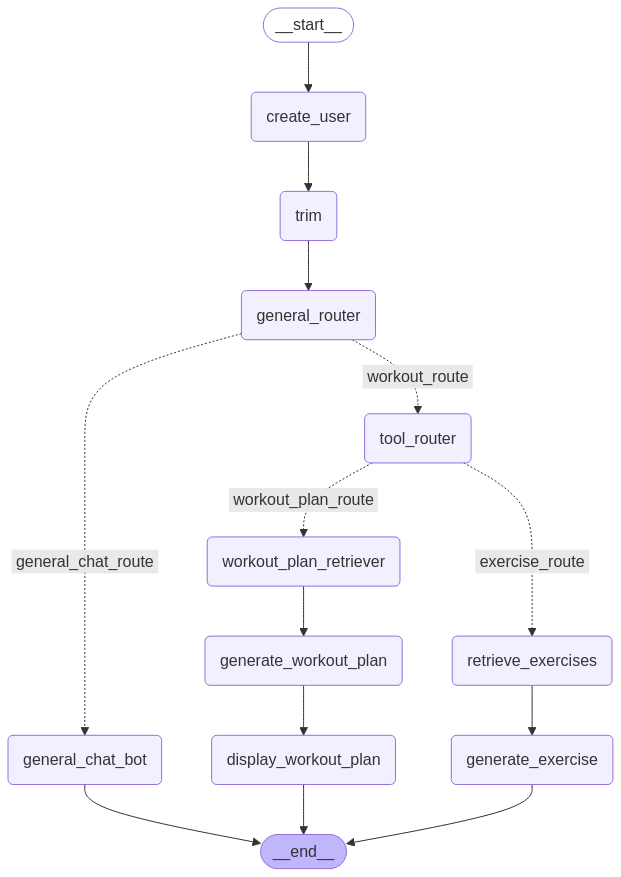

In [44]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("ERROR :(")
    pass

### Chat and testing

In [45]:
config = {"configurable": {"thread_id": "1"}}

In [46]:
 #input_message = [HumanMessage(content="What rank is Tri the Tree?")]
 #output = app.invoke({"messages":input_message},config=config)
 #output["messages"][-1].pretty_print()

In [47]:
# input_message = [HumanMessage(content="How to make butter chicken"),
#                  HumanMessage(content="Help me create a workout plan for the week"),
#                  HumanMessage(content="What is the capital of France")]

input_message = [HumanMessage(content="Give me a workout plan for upper body workouts"),]

for input_m in input_message:
    output = app.invoke({"messages":input_m},config=config)
    output["messages"][-1].pretty_print()

reached general state
---ROUTE QUESTION (GENERAL)---
---ROUTE QUESTION TO workout---
reached workout state
---ROUTE QUESTION (TOOLS)---


No relevant docs were retrieved using the relevance score threshold 0.8


---ROUTE QUESTION TO workout PLAN---
---workout PLANNER RETRIEVER---
---workout PLANNER GENERATOR---
---DISPLAY workout PLAN---
workout plan:  {'Squats': ['The squat is a compound exercise that targets the quadriceps, hamstrings, glutes, and core muscles, and is considered a fundamental movement for building strength and power in the lower body.', 'Legs', 'Barbell'], 'Deadlifts': ['The deadlift is a compound exercise that targets the quadriceps, hamstrings, glutes, back, and core muscles, and is considered one of the most effective exercises for building overall strength and power.', 'Legs', 'Barbell'], 'Lunges': ['The lunge is a compound exercise that targets the quadriceps, hamstrings, glutes, and core muscles, and is effective for building strength, power, and endurance in the lower body.', 'Legs', 'Barbell']}
================================ Human Message =================================

Give me a workout plan for upper body workouts
